In [68]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [71]:
# Use y_finance to get desired stock.
aapl = yf.download('AAPL', start="2020-01-01", end="2021-01-01")

std_scaler = MinMaxScaler()

# Calculate how many dates are in the file and add a column
aapl['Date_Id'] = (aapl.index.date - aapl.index.date.min()).astype('timedelta64[D]')
aapl['Date_Id'] = aapl['Date_Id'].dt.days + 1
aapl.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

# Add adj high and low, which may be important later
aapl['Adj_High'] = aapl['Adj_Close'] * aapl['High'] / aapl['Close']
aapl['Adj_Low'] = aapl['Adj_Close'] * aapl['Low'] / aapl['Close']
aapl.columns = [x.lower() for x in aapl.columns]
data = std_scaler.fit_transform(aapl.to_numpy())
data = pd.DataFrame(data, columns=aapl.columns)
data.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj_close,volume,date_id,adj_high,adj_low
0,0.210292,0.220719,0.254288,0.235677,0.231024,0.233767,0.000000,0.216244,0.249556
1,0.213100,0.220658,0.258322,0.226620,0.222082,0.262313,0.002747,0.216183,0.253539
2,0.202734,0.218760,0.246774,0.233971,0.229339,0.188763,0.010989,0.214310,0.242137
3,0.221399,0.221637,0.261340,0.229598,0.225022,0.163712,0.013736,0.217150,0.256519
4,0.213131,0.232474,0.260354,0.244487,0.239720,0.224812,0.016484,0.227848,0.255546


In [73]:
# Create a linear model from the close and date
data = data.filter(['date_id','adj_close'], axis=1)
data.insert(0, 'ones', 1)
cols = data.shape[1]
X = data.iloc[:,0:cols-1] # iloc slicing function
X = np.asarray(X.values)
Y = data.iloc[:,cols-1:cols]
Y = np.asarray(Y.values)
theta = np.asarray([np.array([0,0])]).T

In [74]:
X.shape, Y.shape, theta.shape

((253, 2), (253, 1), (2, 1))

In [75]:
model = linear_model.LinearRegression(fit_intercept = False)
model.fit(X, Y)
print(model.coef_) # get theta coefficients (model params)

[[0.03448446 0.96182432]]


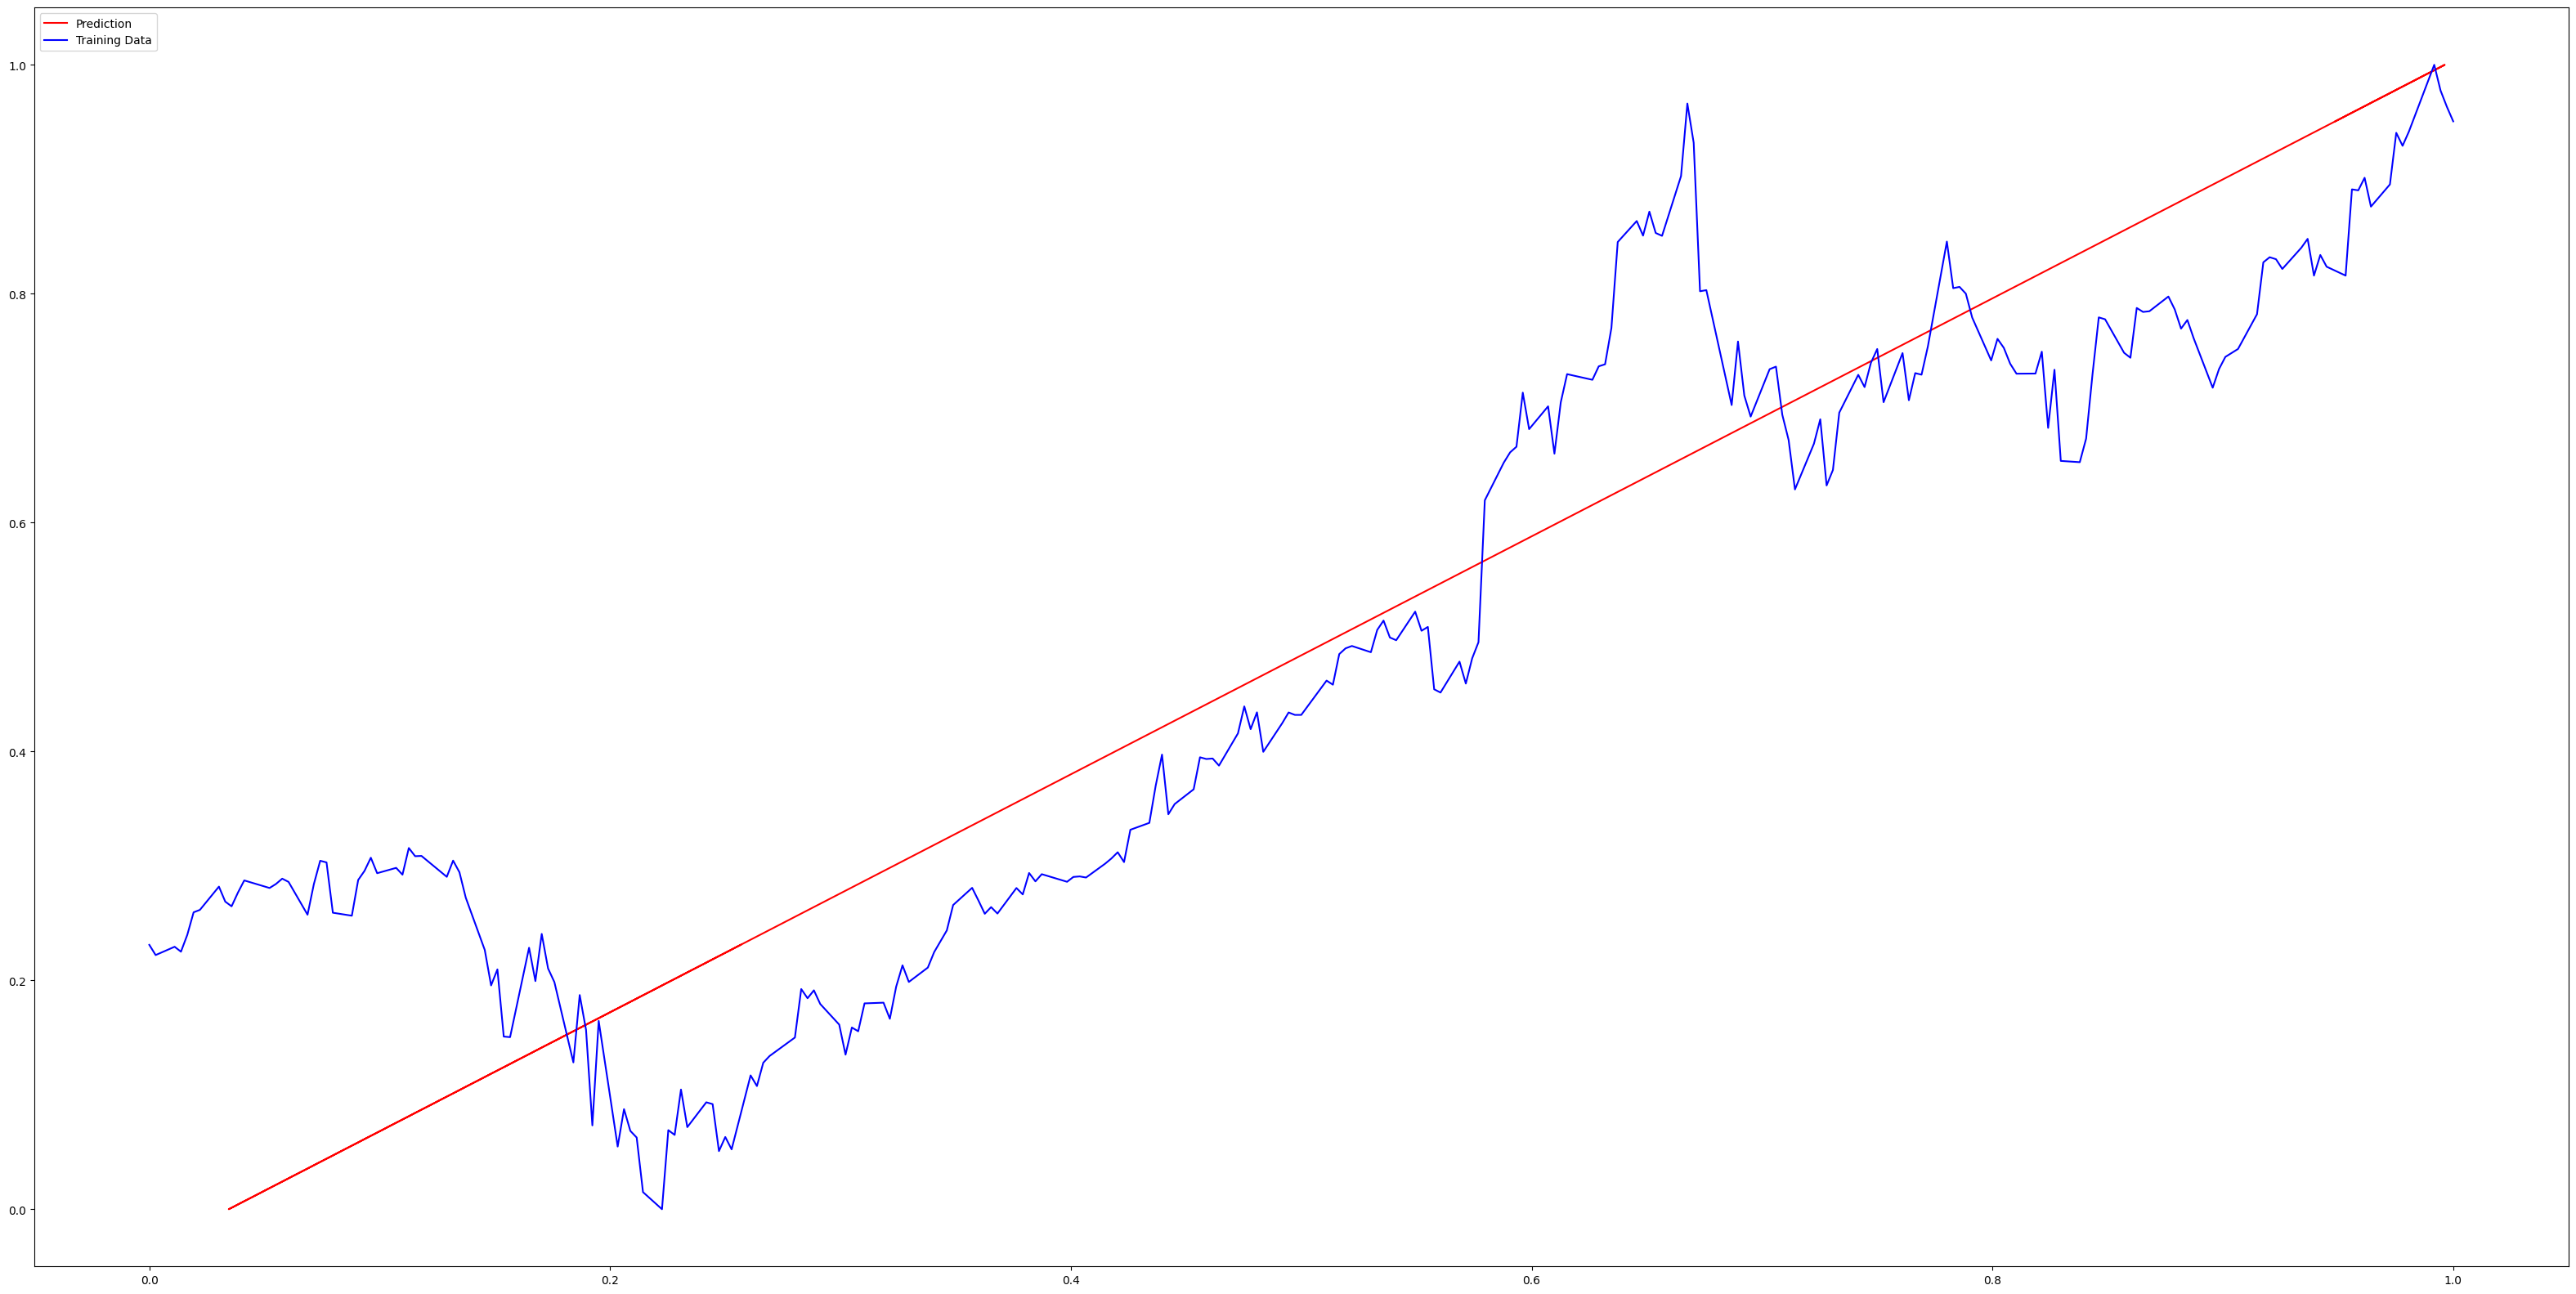

In [77]:
# Graph the model
x = np.array(np.ravel(X[:, -1]))
lobf = model.predict(X).flatten()

fig, ax = plt.subplots(figsize=(40,20))
ax.plot(lobf, x, color = "red", label='Prediction')
ax.plot(Y, X[:, 1], color = "blue", label='Training Data')
ax.legend(loc=2)

In [48]:
# Calculate points along the line of best fit
data_points = np.asarray(data['Adj_Close'])

# Calculate the upper and lower pivot points relative to the line of best fit
# Upper/Lower pivots are the indecies of the data points that are the furthest from the line of best fit
upper_pivot = (data_points - lobf).argmax()
lower_pivot = (data_points - lobf).argmin()
print(upper_pivot, lower_pivot)

KeyError: 'Adj_Close'

In [6]:
# Function to be optimized by gradient descent 
# Reference: https://github.com/neurotrader888/TrendLineAutomation/blob/main/trendline_automation.py
# Lines 6-24
def check_trend_line(upper, pivot, slope, y):
    # Find intercept of line going through pivot point
    intercept = -slope * pivot + y[pivot]
    line_values = slope * np.arange(len(y)) + intercept
    differences = line_values - y

    # Check to see if line is valid, if not return -1
    if upper and differences.max() > 1e-5:
        return -1.0
    elif not upper and differences.min() < -1e-5:
        return -1.0
    
    # Squared sum of differences between data and line
    error = (differences ** 2.0).sum()
    return error

# Sanity check
check_trend_line(True, lower_pivot, model.coef_[0][1], data_points)

-1.0

In [7]:
# TODO: Minimize the error function using gradient descent